---
# **Sección 1: Lógica del proceso**
---

---
**Importar Bibliotecas**
---

In [ ]:
## Importar Bibliotecas ##

import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

---
**Parámetros para Generador de Ventanas**
---

**Generar la clase WindowGenerator con 7 parámetros y métodos especiales __init__ (para inicializar argumentos) y __repr__ (para devolver una cadena que muestra una representacion del objeto)**

In [ ]:
## I. Carga y preprocesamiento ##

# Abrir el archivo desde Drive
drive.mount('/content/drive')
prod_dir = '/content/drive/MyDrive/Datos/Queretaro_Products4_english.csv'
white_dir = '/content/drive/MyDrive/Datos/white_noise_english.csv'
f = open(prod_dir, encoding='latin_1')
g = open(white_dir, encoding='latin_1')

# Leer el CSV, guardarlo como un dataframe, ponerle un nombre y eliminar columnas que no considere necesarias
prod_dataframe = pd.read_csv(f, header=None, sep=',', names=['Fecha', 'Producto', 'Precio', 'Stub'] , index_col='Producto')
prod_dataframe.drop(labels='Stub', axis=1, inplace=True)
prod_dataframe.columns.name = 'Product Batch'

prod_white = pd.read_csv(g, header=None, sep=',', names=['Fecha', 'Producto', 'Precio', 'Stub'] , index_col='Producto')
prod_white.drop(labels='Stub', axis=1, inplace=True)
prod_white.columns.name = 'White Batch'

array_date = prod_dataframe['Fecha']

# Guardar cada producto en un array
all_products = np.array(prod_dataframe.index.unique())
all_white = np.array(prod_white.index.unique())
print(pd.DataFrame(all_products,))
print(pd.DataFrame(all_white))

Mounted at /content/drive
                         0
0          Big Cauliflower
1                Big Nopal
2         Italian Zucchini
3      Non-Prickly Chayote
4                   Peanut
5         Saladette Tomato
6      Big Valencia Orange
7             Hass Avocado
8                     Kiwi
9                    Lemon
10                    Lime
11             Male Banana
12          Tabasco Banana
13  Medium-sized Pineapple
14          Red Grapefruit
15                 Epazote
16                  Jicama
                        0
0      D Anjou #100 pear
1        Dominican Banana
2  Golden Delicious Apple
3              Strawberry
4      Striped Watermelon
5     Red Delicious Apple


In [ ]:
# II. Generador de Ventanas #
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    
    # Pasar los dataframes-parámetros como atributos 
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.train_df_mean = self.train_df.mean()
    self.train_df_std = self.train_df.std()

    self.train_df = (self.train_df - self.train_df_mean) / self.train_df_std
    self.val_df = (self.val_df - self.train_df_mean) / self.train_df_std
    self.test_df = (self.val_df - self.train_df_mean) / self.train_df_std

    # Crea dos diccionarios nombre-indice, uno con las etiquetas (si se ingresaron), 
    # y otro de las características del conjunto de entrenamiento.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Crea la anchura de la ventana de ENTRADA, el DESPLAZAMIENTO 
    # y la diferencia será la ventana de SALIDA (por lo tanto "shift >= 1" en SALIDA).
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    # self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.input_indices = array_date[self.input_slice]

    self.label_start = self.total_window_size - self.label_width # Evitar que de negativo respetando "label_width <= total_window_size"
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

---
**El Rebanador de Ventanas**
---

In [ ]:
 # Dada una lista de entrada consecutivas los convierte en entradas y etiquetas 
 # LLAMÉMOSLE "EL REBANADOR" para UNA ventana
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing no preserva información estática de la forma, hay que ajustar las formas 
  # manualmente. De esta manera `tf.data.Datasets` son más fáciles de inspeccionar.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

---
**El Graficador**
---

In [ ]:
# Graficar de manera individual la ventana
def plot(self, model=None, plot_col='Precio', max_subplots=3, mean=0, std= 1, product_name='None', y_label='Price', x_label='Weeks'):
  
  # Extraer la ventana del conjunto de ejemplo
  inputs, labels = self.example

  plot_col_index = self.column_indices[plot_col] # Nos devuelve el índice asociado a la columna (en el caso del precio es el cero)
  max_n = min(max_subplots, len(inputs)) # Representa el número de subgraficos siendo 3 o menos (si las entradas (inputs) tienen menos de tres elementos)
  
  # Toda esta sección busca construir el gráfico: define el gráfico, los subgraficos, las etiquetas, etc. 
  plt.figure(figsize=(12, 8)) # Crea la figura
  plt.suptitle(f'Product Forecast: {product_name}', fontsize='xx-large', weight='roman')
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1) # Agrega un subgrafico a la figura actual (num_filas, num_columnas, índice)
    plt.ylabel(f'{y_label}') # Etiqueta del eje "y" (en este caso la etiqueta es "price")
    
    # Grafica en los ejes "x"(los indices de la ventana de entrada) y "y" (precios correspondiente a "muestra n", y "columna plot_co_index")
    # Color reemplazado #1F77B4 (azul por default en gráficas) a escala de grises '#636363'
    plt.plot(self.input_indices, (inputs[n, :, plot_col_index] * std) + mean, 
             label='Historical', marker='*', markersize=15, zorder=-10, color='#636363')  

    # Aquí se busca asignar el índice de la columna a la variable "label_col_index", primero busca validar si se especificó una etiqueta en WindowGenerator mediante 
    # el parámetro "self.label_columns", de ser así buscará la característica a graficar (el paramétro "plot_col") en el diccionario "label_columns_indices" (creado al inicio del código), 
    # en caso de contrario (que no haya etiqueta y por tanto no haya diccionario), "plot_col" buscará en el diccionario "label_index"

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    


    # Si no hay etiquetas (labels) porque no se específico en los parámetros iniciales, el gráfico se salta a la siguiente etiqueta (para ello se usa el comando "continue")
    if label_col_index is None:
      continue
    
    # Ya una vez asegurado que existen datos para etiquetas, con las siguientes lineas se grafican, de esta manera se evitan errores de graficado
    # *color desechado '#2ca02c' (verde hexadecimal)
    plt.scatter(self.label_indices, (labels[n, :, label_col_index] * std) + mean,
                edgecolors='k', label='Current', c='#707070', s=64)
    
    # Si se especifica un parámetro diferente de "None" en el modelo (es decir que se esté evaluando un modelo), se grafican las predicciones de este
    # en caso contrario no grafican predicciones; *Color desechado '#ff7f0e' (naranja hexadecimal)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, (predictions[n, :, label_col_index] * std) + mean,
                  marker='X', edgecolors='k', label='Target',
                  c='#989898', s=64)        
    # Crea una leyenda solo en la primer subgrafica.
    if n == 0:
      plt.legend()
  
  plt.xlabel(x_label)
  plt.savefig('/content/drive/MyDrive/Datos/product.svg', dpi=600, format='svg')
        
WindowGenerator.plot = plot

---
**El Generador de Ventanas (Que serán rebanadas con el rebanador)**
---

In [ ]:
# Crear diferentes ventanas donde cada una será modificada por split_window (EL REBANADOR)
def make_dataset(self, data):

  data = np.array(data, dtype=np.float32) # Convierte el DataFrame a Numpy Array
  
  # Crea  ventanas COMPLETAS y las almacena en un lote (Dataset)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      sampling_rate=1,
      shuffle=False,
      batch_size=data.shape[0])
  
  # Rebana cada ventana (".map" aplica EL REBANADOR a cada elemento/ventana) y los vuelve a guardar en el lote (Dataset)
  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# Hacer tres DATASETS de Vetanas Rebanadas para los conjuntos entrenamiento, validación y prueba (y uno extra de ejemplo para graficar)
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Obtiene y guarda un lote de ejemplos `inputs, labels` para graficar."""
  result = getattr(self, '_example', None)
  if result is None:
    # Si el ejemplo no se encuentre se obtiene del dataset `.train`
    result = next(iter(self.train))
    # Lo guarda para la siguiente vez
    self._example = result
  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

---
**Los Modelos de Predicción**
---

In [ ]:
## III. Creación de Modelos. ##

MAX_EPOCHS=1500
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.RMSprop(),
                metrics=[tf.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=False)
  return history


# #  Modelo Base (Modelo Ingenuo) # #
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index] # Filtra las características a una
    return result[:, :, tf.newaxis] # Agrega una dimension extra al final

    

# #  Red Recurrente SimpleRNN # #
simple_rnn = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, simplernn_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation=None)
])

---
# **Sección 2: Experimentación con Datos**
---

---
**Carga los CSV en DataFrames con su respectiva lista**
---

---
**Aplicador del Modelo**
---

In [ ]:
# III. Aplicación del Modelo

class AppliedWindow:
  
  def __init__(self, product_index, start_year, train_percent, val_percent, data, input_width=8, label_width=8, shift=1, label_columns=['Precio']):
    self.product_index = product_index
    self.start_year = start_year
    self.train_percent = train_percent
    self.val_percent = val_percent
    self.data = data
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.label_columns = label_columns
    self.all_products = np.array(data.index.unique()) # Lista todos los productos
    self.product_name = self.all_products[self.product_index]

  def __call__(self):

    # 1. Generar el DataFrame #
    self.product = self.data.loc[self.all_products[self.product_index]]
    self.product.name = self.all_products[self.product_index] # Nombrar el DataFrame
    dt = pd.to_datetime(self.product.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
    self.product.index = dt # Colocar el objeto DateTime como índice
    self.product = self.product.resample('W').mean() #Obtener los promedios semanales
    self.product = self.product[self.start_year:]
    # self.fluctuation = (self.product.shift(periods=-1) - self.product)/self.product
    # self.fluctiation = self.product.dropna()
    self.column_indices = {name: i for i, name in enumerate(self.product.columns)} # Generar un diccionario con la relación índice/columna

    # 2. Separar los datos, Nota: es importante monitorear que el conjunto de testeo sea lo suficientemente ancho para lo que requiere la ventana#
    self.n_periods = len(self.product)
    self.product_train = self.product[0 : int(self.n_periods * self.train_percent)]
    self.product_val = self.product[int(self.n_periods * self.train_percent) : int(self.n_periods * (self.train_percent+self.val_percent))]
    self.product_test = self.product[int(self.n_periods * (self.train_percent+self.val_percent)) : None]
    
    
    # 3. Normalizar los datos #
    self.product_train_mean = self.product_train.mean()
    self.product_train_std = self.product_train.std()

    self.product_train = (self.product_train - self.product_train_mean) / self.product_train_std
    self.product_val = (self.product_val - self.product_train_mean) / self.product_train_std
    self.product_test = (self.product_test - self.product_train_mean) / self.product_train_std
    

    # 4. Crear un Modelo de Desplazamiento #
    self.n_step_window = WindowGenerator(train_df=self.product_train, val_df=self.product_val, test_df=self.product_test, 
                                         input_width=self.input_width, label_width=self.label_width, shift=self.shift, label_columns=self.label_columns)
    
    
    
    # 5. Rendimiento  con el modelo base #
    self.val_performance = {}
    self.performance = {}
    
    print('****MODELO BASE****')
    baseline = Baseline(label_index=self.column_indices['Precio'])
    baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.RootMeanSquaredError()])
    self.val_performance['Baseline'] = baseline.evaluate(self.n_step_window.val, verbose=True)
    self.performance['Baseline'] = baseline.evaluate(self.n_step_window.test, verbose=True)
    self.n_step_window.plot(baseline, mean=self.product_train_mean, std=self.product_train_std, product_name=self.product_name)
    
    #6. Rendimiento con la red recurrente ##
    print('****MODELO RECURRENTE****')
    history = compile_and_fit(simple_rnn, self.n_step_window)
    IPython.display.clear_output()
    self.val_performance['simple_rnn'] = simple_rnn.evaluate(self.n_step_window.val, verbose=False)
    self.performance['simple_rnn'] = simple_rnn.evaluate(self.n_step_window.test, verbose=False)
    self.n_step_window.plot(model=simple_rnn, mean=self.product_train_mean, std=self.product_train_std, product_name=self.product_name)

  
    return print("El rendimiento del método de redes neuronales es:", self.performance, self.product )

# **Seccion 3.1: Productos Evaluados (evaluables con ARIMA)**

---
**0. Coliflor**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.21680378913879395, 0.4656219482421875], 'simple_rnn': [0.12266754359006882, 0.35023927688598633]} Product Batch  Precio
Fecha                
2017-01-01       10.9
2017-01-08       10.9
2017-01-15       10.5
2017-01-22       10.8
2017-01-29       11.8
...               ...
2019-01-20       12.8
2019-01-27       12.8
2019-02-03       12.6
2019-02-10       13.0
2019-02-17       12.8

[112 rows x 1 columns]


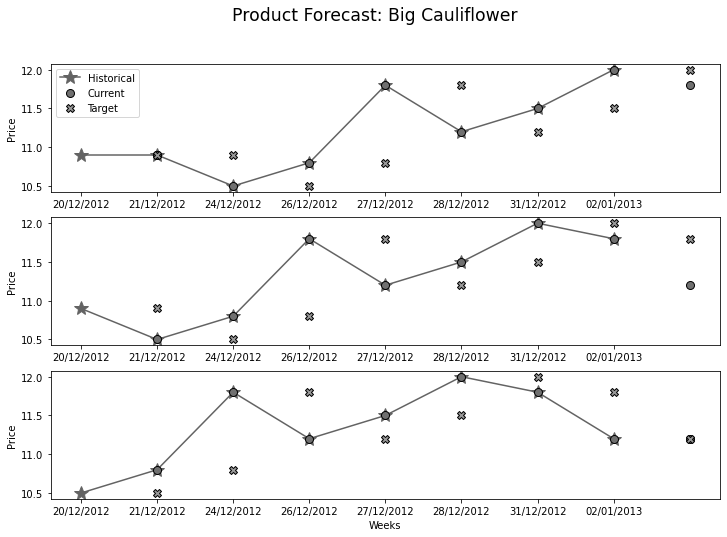

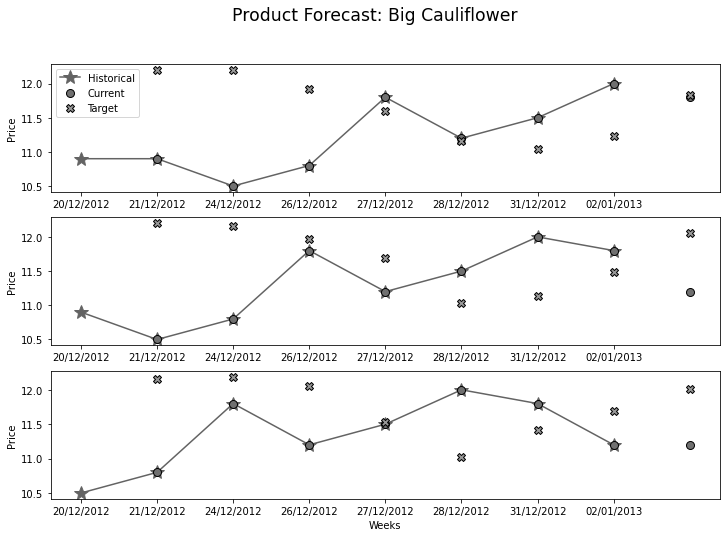

In [ ]:
Coliflor = AppliedWindow(product_index=0, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Coliflor()
# Dada un paso de entrada, predigo una semana hacia el futuro (existe un espacio hueco porque ya no hay a donde avanzar hacia el futuro, por lo tanto ya no dibuja la linea al final)
# Current es el precio real

---
**1. Nopal Grande**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.04673977568745613, 0.21619383990764618], 'simple_rnn': [0.055314648896455765, 0.23519065976142883]} Product Batch  Precio
Fecha                
2017-01-01      13.20
2017-01-08      13.70
2017-01-15      13.60
2017-01-22      12.20
2017-01-29      12.00
...               ...
2019-01-20      15.00
2019-01-27      12.40
2019-02-03      12.00
2019-02-10      12.25
2019-02-17      10.60

[112 rows x 1 columns]


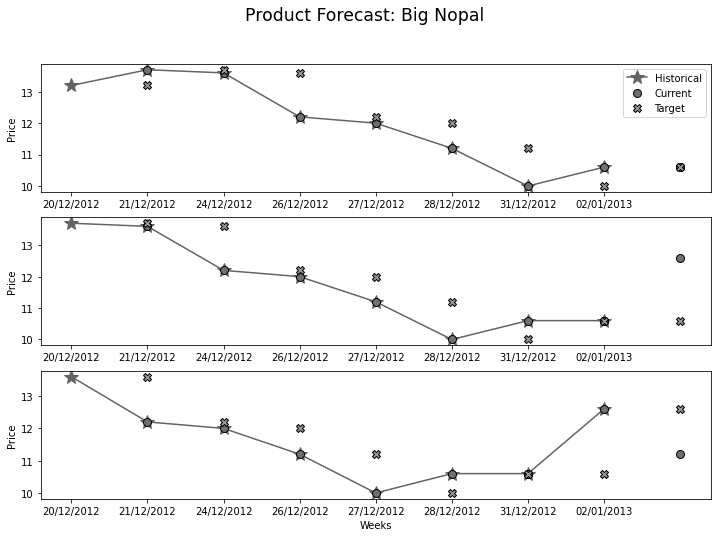

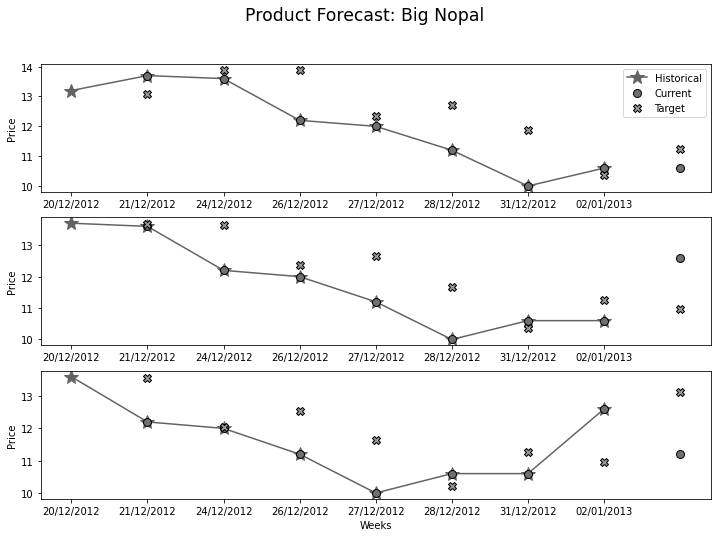

In [ ]:
Nopal_G = AppliedWindow(product_index=1, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Nopal_G()

---
**2. Calabacita Italiana**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.1354169398546219, 0.3679904043674469], 'simple_rnn': [0.1273232251405716, 0.35682380199432373]} Product Batch  Precio
Fecha                
2017-01-01       6.56
2017-01-08       6.56
2017-01-15      12.00
2017-01-22      13.20
2017-01-29       8.48
...               ...
2019-01-20      16.48
2019-01-27      12.64
2019-02-03      10.00
2019-02-10       8.80
2019-02-17       8.96

[112 rows x 1 columns]


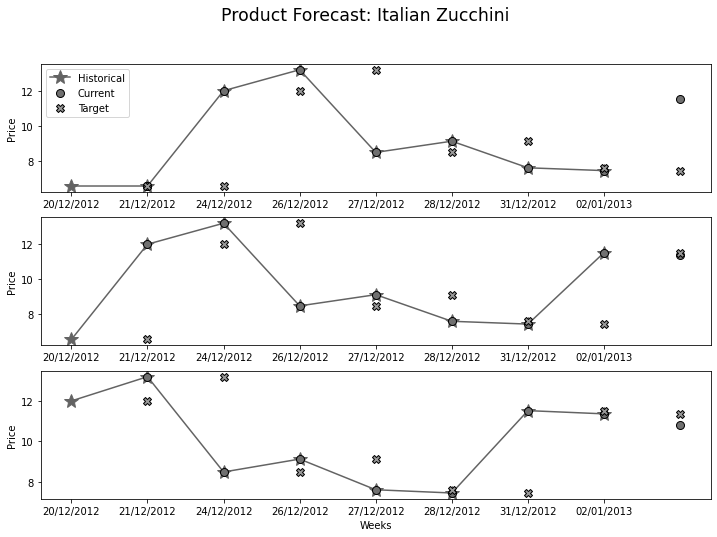

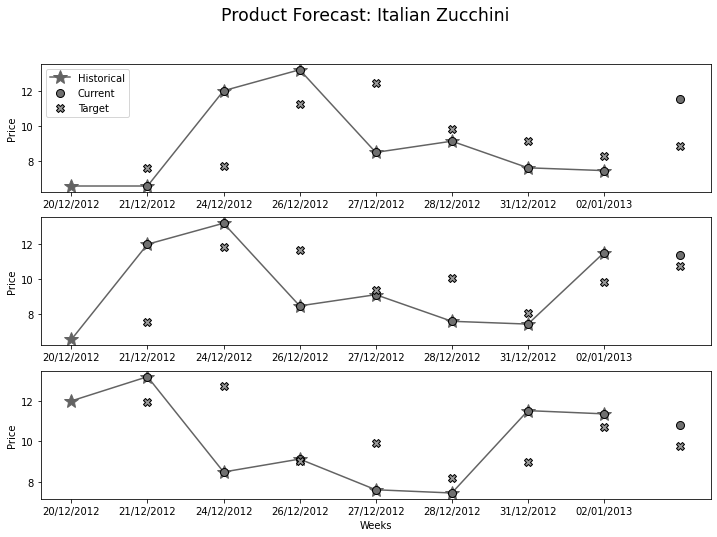

In [ ]:
Calabacita_I = AppliedWindow(product_index=2, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Calabacita_I()

---
**3. Chayote Sin Espinas**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.3874465525150299, 0.6224520206451416], 'simple_rnn': [0.34554973244667053, 0.5878347754478455]} Product Batch   Precio
Fecha                 
2017-01-01      5.5780
2017-01-08      5.3660
2017-01-15      5.9980
2017-01-22     10.0000
2017-01-29      8.9480
...                ...
2019-01-20     11.2640
2019-01-27     10.2100
2019-02-03     15.0520
2019-02-10     16.1825
2019-02-17     14.2120

[112 rows x 1 columns]


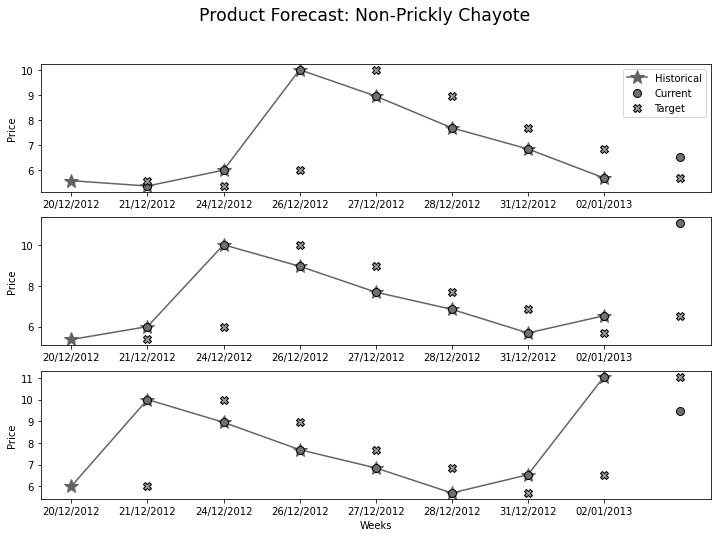

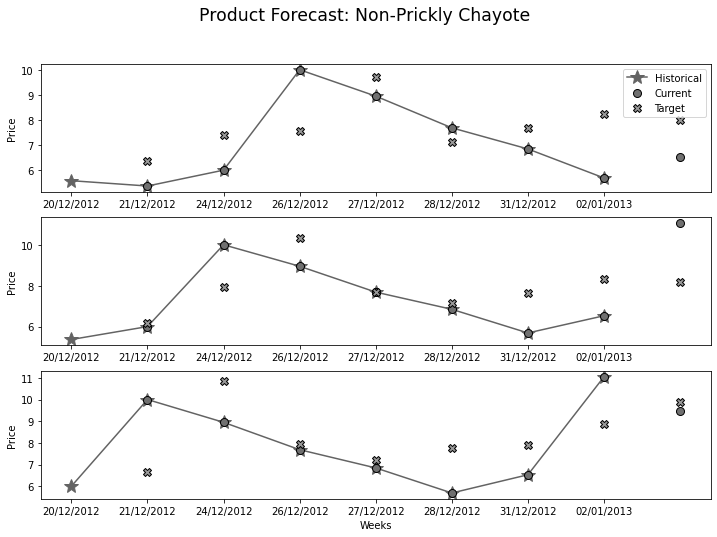

In [ ]:
Chayote = AppliedWindow(product_index=3, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Chayote()

---
**4. Cacahuate**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.03931687772274017, 0.1982848346233368], 'simple_rnn': [0.10834421217441559, 0.3291568160057068]} Product Batch  Precio
Fecha                
2016-01-03       34.0
2016-01-10       32.8
2016-01-17       34.0
2016-01-24       35.0
2016-01-31       35.0
...               ...
2019-01-20       65.2
2019-01-27       65.8
2019-02-03       66.0
2019-02-10       66.0
2019-02-17       66.6

[164 rows x 1 columns]


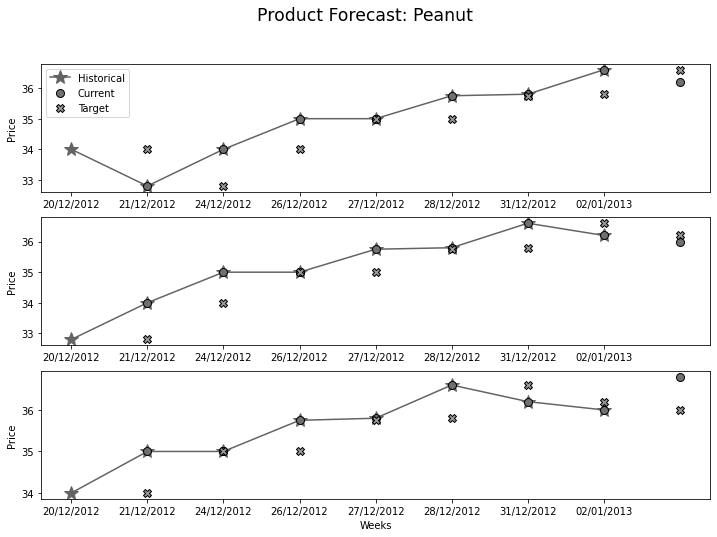

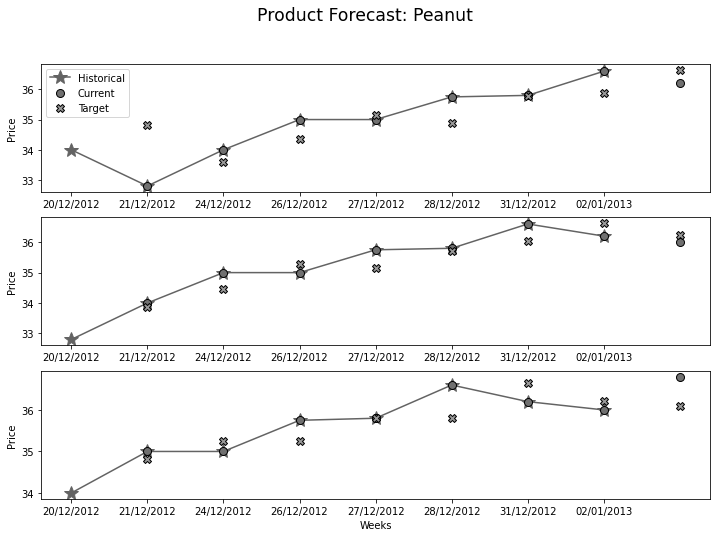

In [ ]:
Cacahuate = AppliedWindow(product_index=4, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Cacahuate()

---
 **5. Tomate Saladette**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.08422098308801651, 0.29020851850509644], 'simple_rnn': [0.0901719480752945, 0.3002864420413971]} Product Batch  Precio
Fecha                
2017-01-01     16.000
2017-01-08     16.000
2017-01-15      9.200
2017-01-22      6.336
2017-01-29      6.334
...               ...
2018-11-04     14.585
2018-11-11     17.932
2018-11-18     20.402
2018-11-25     23.500
2018-12-02     25.835

[101 rows x 1 columns]


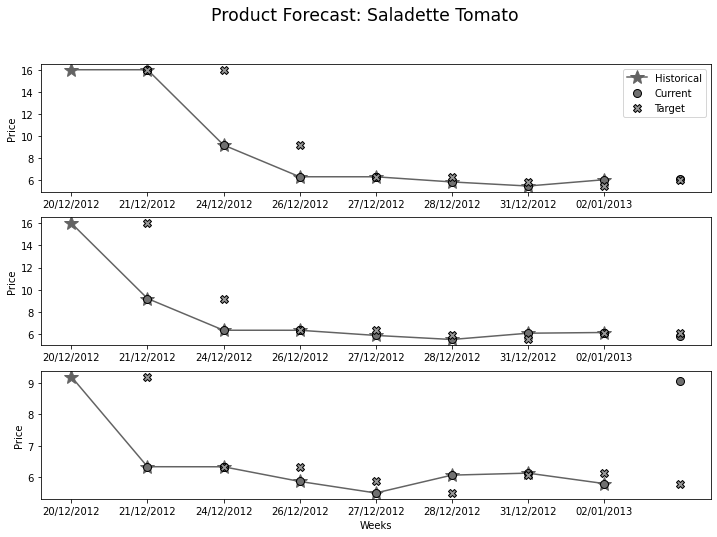

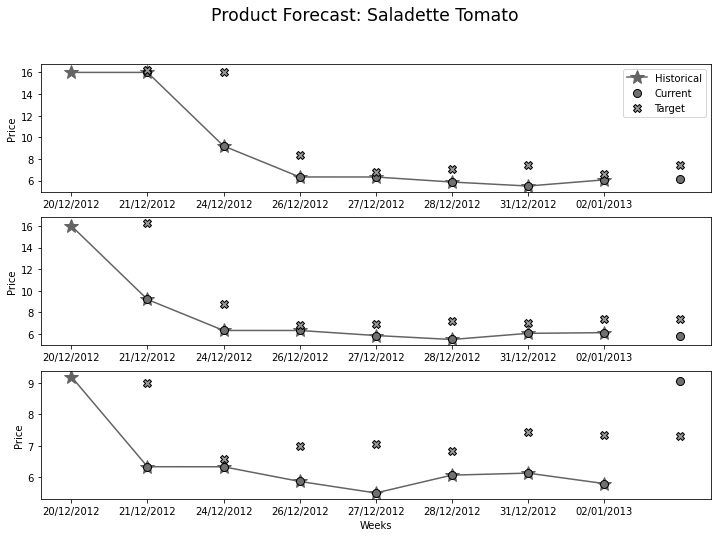

In [ ]:
Tomate_S = AppliedWindow(product_index=5, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Tomate_S()

---
 **6. Naranja Valencia Grande**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.011657828465104103, 0.1079714223742485], 'simple_rnn': [0.01405396033078432, 0.1185493990778923]} Product Batch  Precio
Fecha                
2016-01-03       3.10
2016-01-10       3.16
2016-01-17       3.32
2016-01-24       3.68
2016-01-31       3.64
...               ...
2019-01-20       4.02
2019-01-27       4.24
2019-02-03       4.20
2019-02-10       4.45
2019-02-17       4.06

[164 rows x 1 columns]


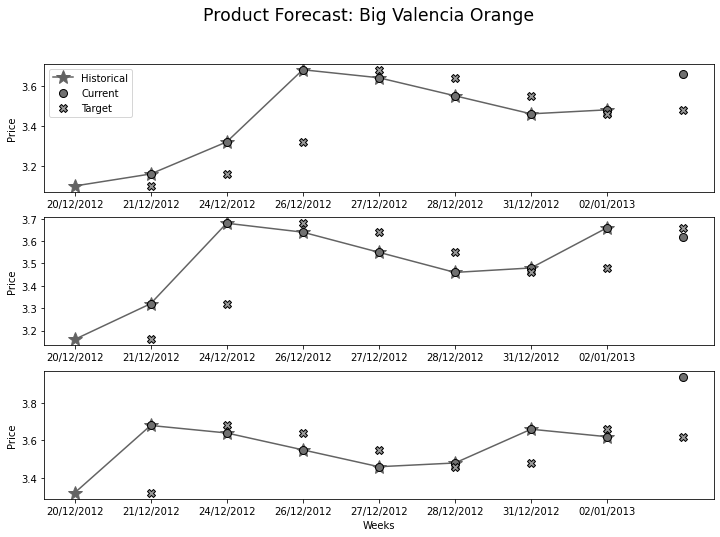

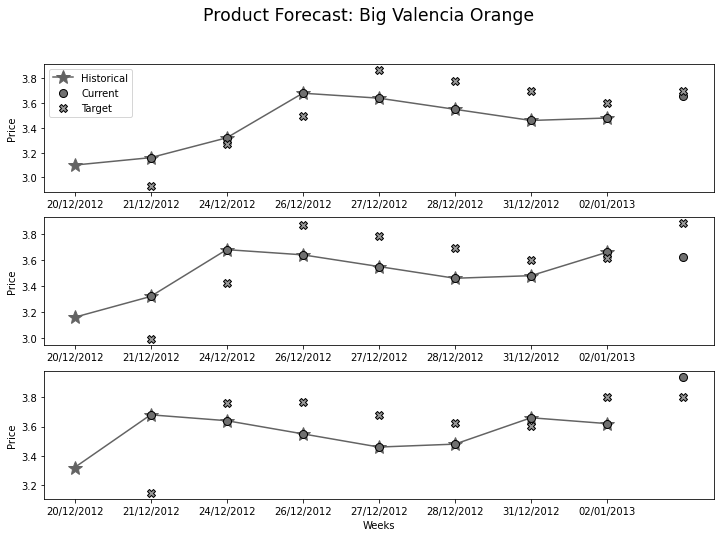

In [ ]:
Naranja_VG = AppliedWindow(product_index=6, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Naranja_VG()

---
 **7. Aguacate Hass**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.005279290024191141, 0.0726587250828743], 'simple_rnn': [0.006144071463495493, 0.07838413119316101]} Product Batch  Precio
Fecha                
2017-01-01      28.40
2017-01-08      28.60
2017-01-15      30.00
2017-01-22      31.00
2017-01-29      32.20
...               ...
2019-01-20      30.00
2019-01-27      29.50
2019-02-03      30.20
2019-02-10      30.75
2019-02-17      31.00

[112 rows x 1 columns]


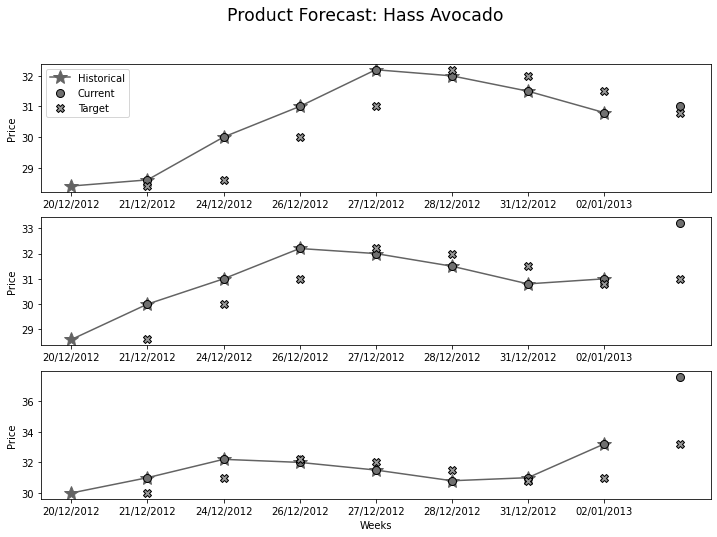

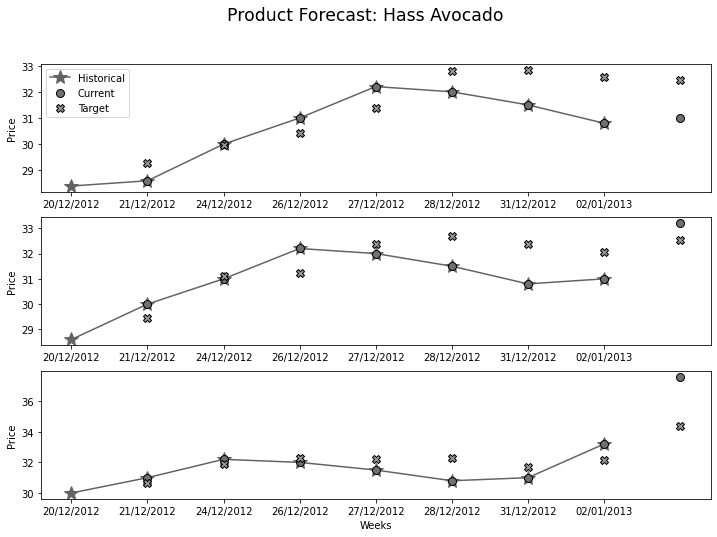

In [ ]:
Aguacate_H = AppliedWindow(product_index=7, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Aguacate_H()

---
 **8. Kiwi**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.009366016834974289, 0.09677818417549133], 'simple_rnn': [0.016750529408454895, 0.1294238418340683]} Product Batch  Precio
Fecha                
2016-01-03      49.75
2016-01-10      47.60
2016-01-17      47.20
2016-01-24      51.80
2016-01-31      53.20
...               ...
2019-01-20      51.00
2019-01-27      58.80
2019-02-03      58.80
2019-02-10      57.00
2019-02-17      57.40

[164 rows x 1 columns]


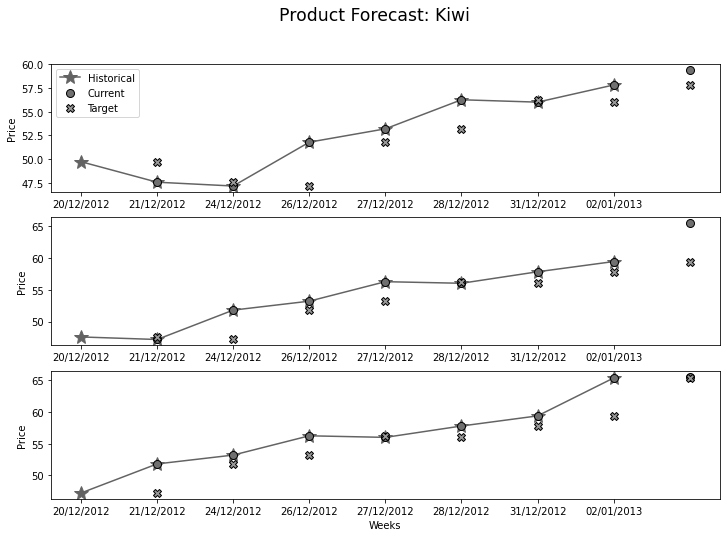

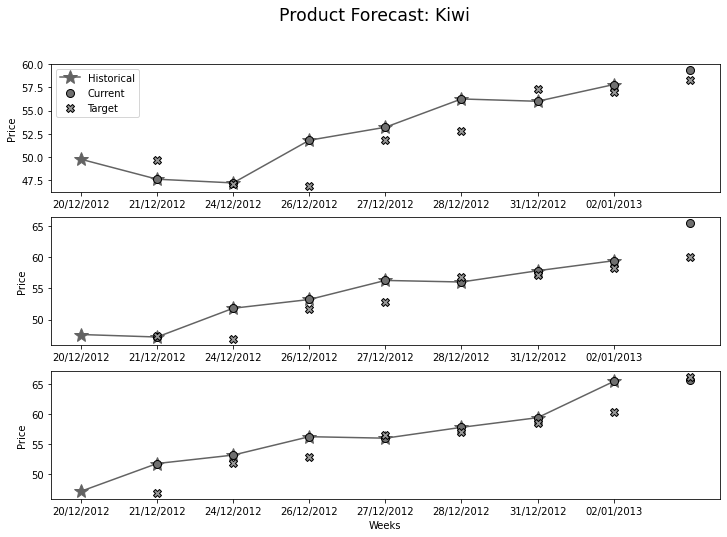

In [ ]:
Kiwi = AppliedWindow(product_index=8, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Kiwi()

---
 **9. Limón**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.06494434922933578, 0.25484180450439453], 'simple_rnn': [0.07226477563381195, 0.2688210904598236]} Product Batch  Precio
Fecha                
2015-01-04      7.625
2015-01-11      6.250
2015-01-18      5.100
2015-01-25      5.300
2015-02-01      5.900
...               ...
2019-01-20      7.300
2019-01-27      7.050
2019-02-03      7.700
2019-02-10      8.625
2019-02-17     10.350

[216 rows x 1 columns]


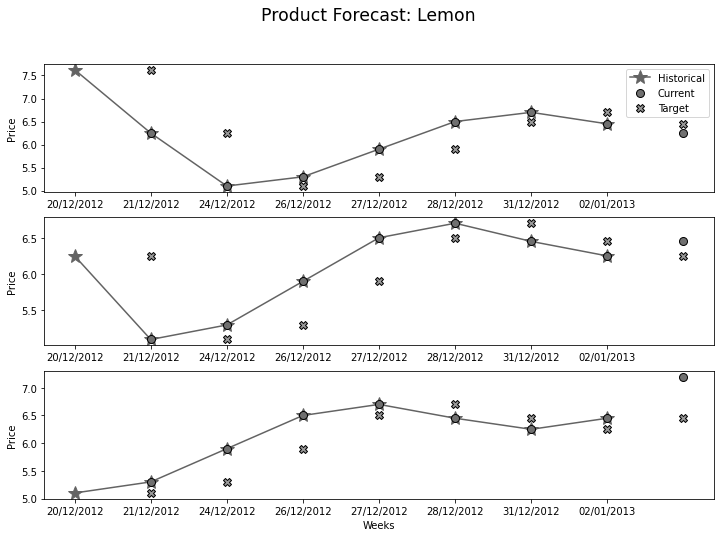

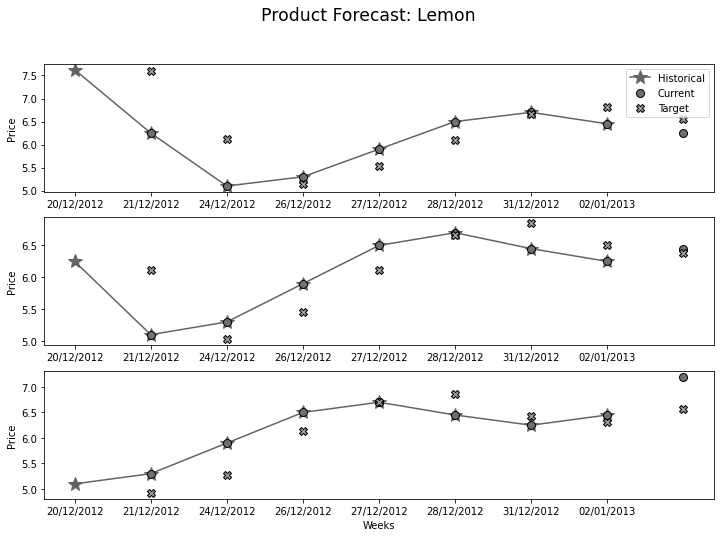

In [ ]:
Limon = AppliedWindow(product_index=9, start_year='2015', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Limon()

---
 **10. Lima**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.017970655113458633, 0.13405467569828033], 'simple_rnn': [0.023609906435012817, 0.15365515649318695]} Product Batch  Precio
Fecha                
2016-01-03       8.50
2016-01-10       8.30
2016-01-17       6.90
2016-01-24       7.20
2016-01-31       7.20
...               ...
2019-01-20      10.00
2019-01-27      10.00
2019-02-03       9.30
2019-02-10       9.25
2019-02-17      10.40

[164 rows x 1 columns]


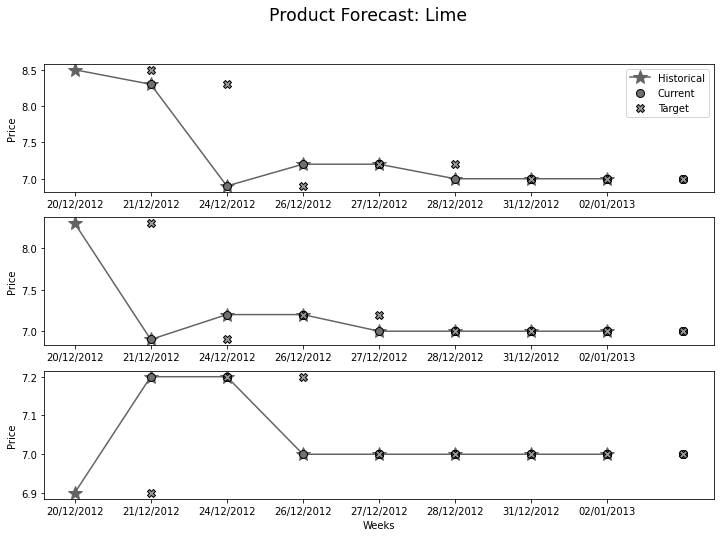

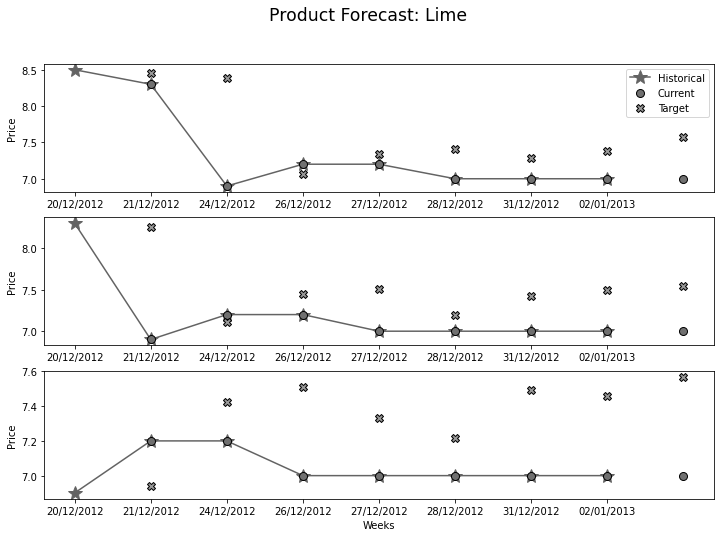

In [ ]:
Lima = AppliedWindow(product_index=10, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Lima()

---
 **11. Plátano Macho**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.14221329987049103, 0.3771117925643921], 'simple_rnn': [0.13359054923057556, 0.36550042033195496]} Product Batch  Precio
Fecha                
2014-01-05      10.00
2014-01-12      10.60
2014-01-19      10.40
2014-01-26      11.40
2014-02-02      12.00
...               ...
2019-01-20      13.80
2019-01-27      14.40
2019-02-03      14.60
2019-02-10      14.25
2019-02-17      13.40

[268 rows x 1 columns]


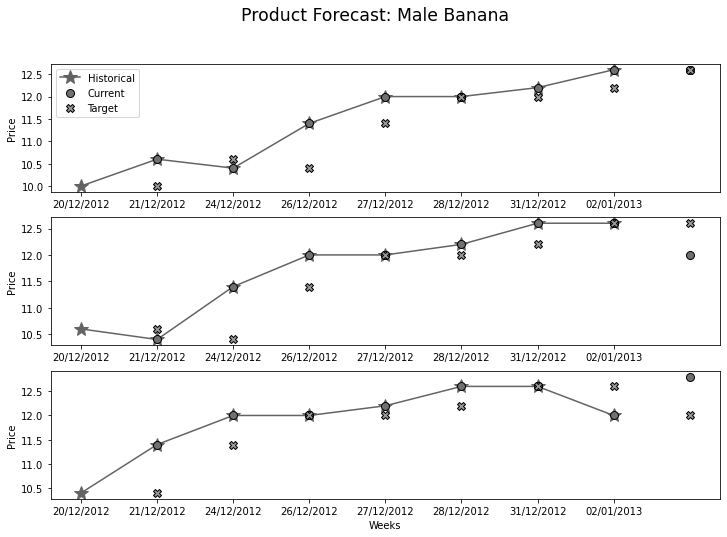

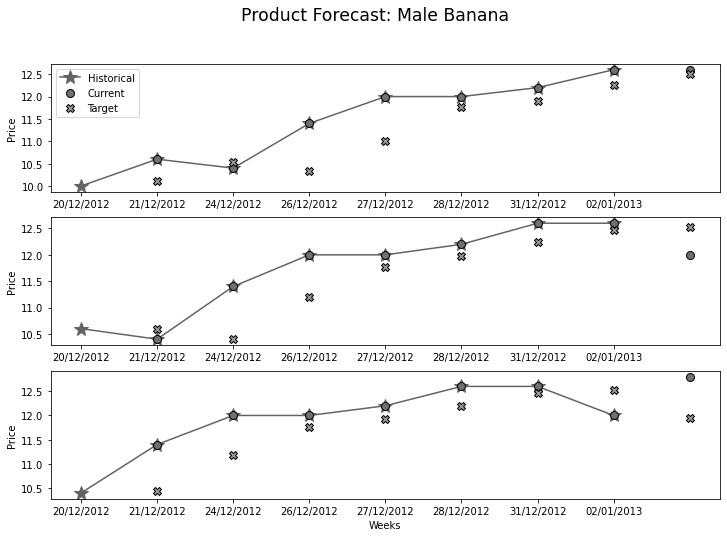

In [ ]:
Platano_M = AppliedWindow(product_index=11, start_year='2014', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Platano_M()

---
 **12. Plátano Tabasco**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.24504031240940094, 0.4950154721736908], 'simple_rnn': [0.22147296369075775, 0.4706091284751892]} Product Batch  Precio
Fecha                
2017-01-01       5.30
2017-01-08       5.40
2017-01-15       5.96
2017-01-22       5.68
2017-01-29       5.68
...               ...
2019-01-20      10.90
2019-01-27      10.86
2019-02-03      10.92
2019-02-10      11.25
2019-02-17      11.16

[112 rows x 1 columns]


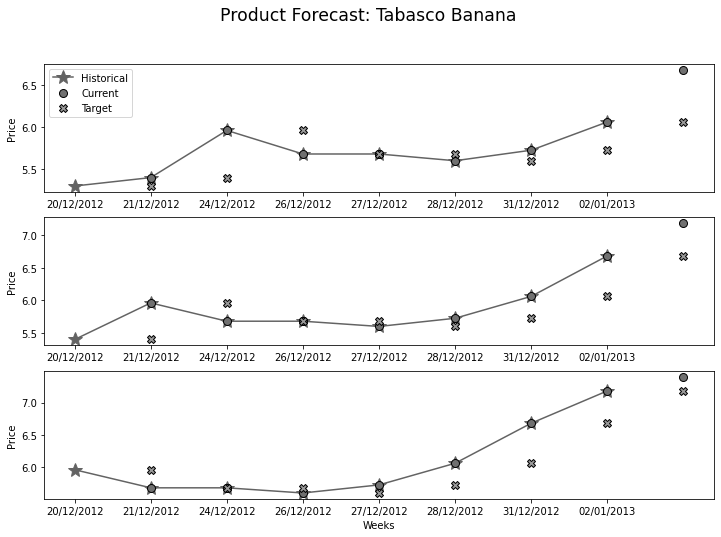

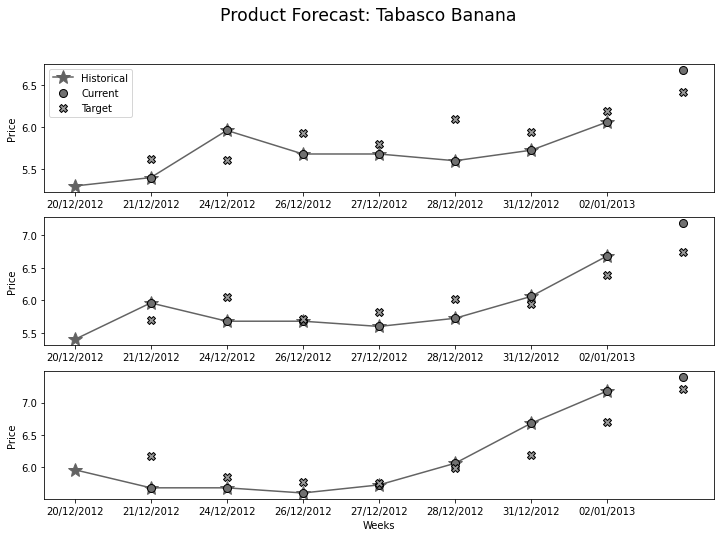

In [ ]:
Platano_T = AppliedWindow(product_index=12, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Platano_T()

---
 **13. Piña Mediana**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.044166892766952515, 0.21015921235084534], 'simple_rnn': [0.04561234638094902, 0.2135704755783081]} Product Batch  Precio
Fecha                
2014-01-05      7.500
2014-01-12      6.600
2014-01-19      7.000
2014-01-26      6.200
2014-02-02      6.000
...               ...
2019-01-20      8.900
2019-01-27      9.200
2019-02-03      9.700
2019-02-10      9.375
2019-02-17      8.900

[268 rows x 1 columns]


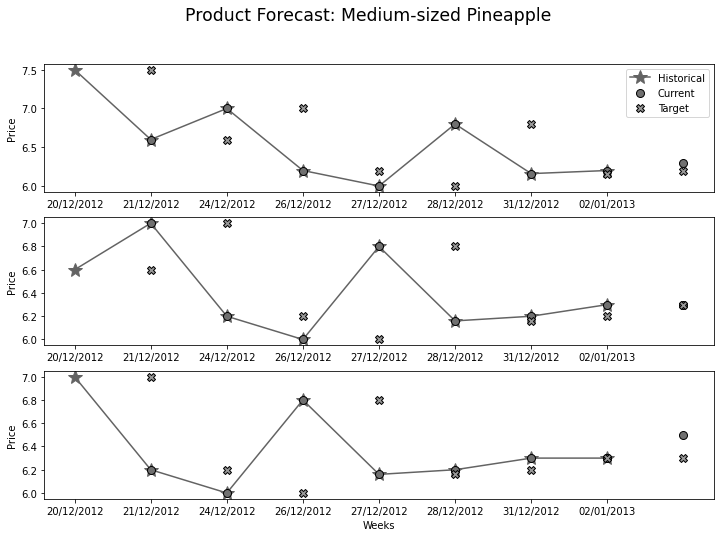

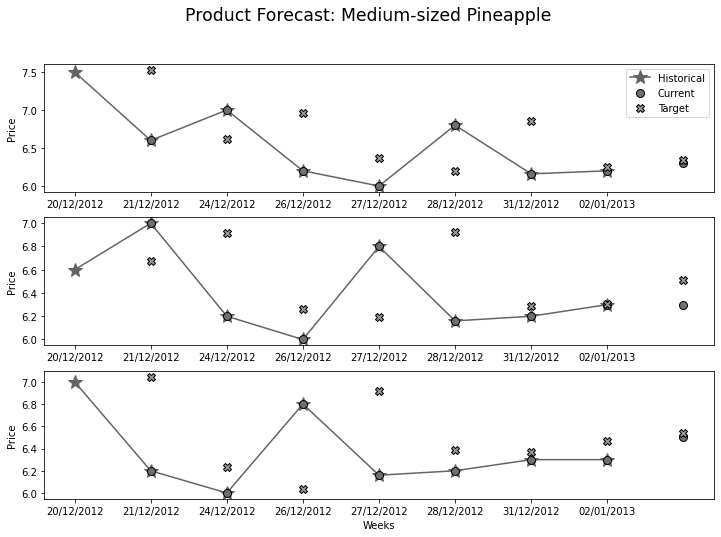

In [ ]:
Pinia_M = AppliedWindow(product_index=13, start_year='2014', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Pinia_M()

---
 **14. Toronja Roja**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.04451188072562218, 0.21097838878631592], 'simple_rnn': [0.04427472874522209, 0.21041561663150787]} Product Batch  Precio
Fecha                
2016-01-03      6.125
2016-01-10      6.600
2016-01-17      4.340
2016-01-24      4.300
2016-01-31      4.800
...               ...
2019-01-20      8.200
2019-01-27      8.900
2019-02-03      8.700
2019-02-10      8.500
2019-02-17      8.200

[164 rows x 1 columns]


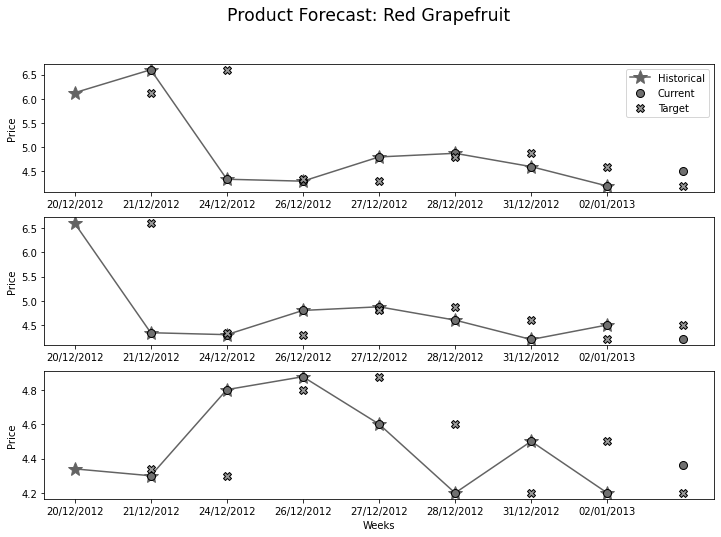

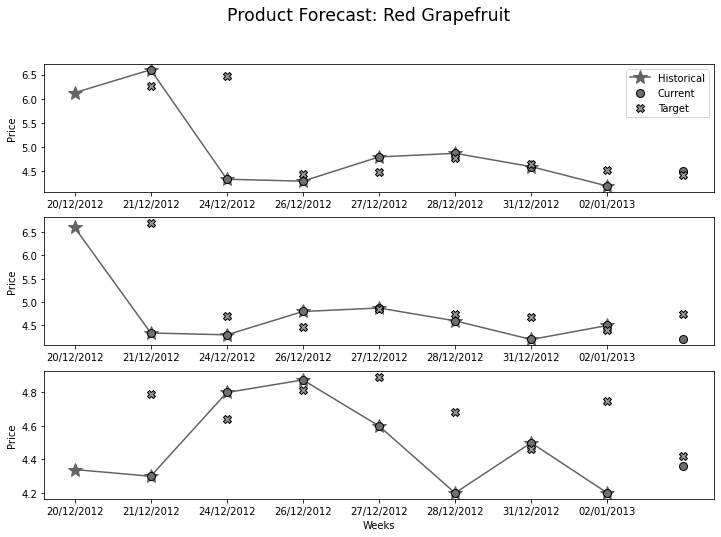

In [ ]:
Toronja_R = AppliedWindow(product_index=14, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Toronja_R()

---
 **15. Epazote**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.13981632888317108, 0.3739202320575714], 'simple_rnn': [0.1452084481716156, 0.38106226921081543]} Product Batch  Precio
Fecha                
2017-01-01      58.00
2017-01-08      59.00
2017-01-15      53.00
2017-01-22      52.00
2017-01-29      58.00
...               ...
2019-01-20      70.00
2019-01-27      67.00
2019-02-03      67.00
2019-02-10      66.25
2019-02-17      64.00

[112 rows x 1 columns]


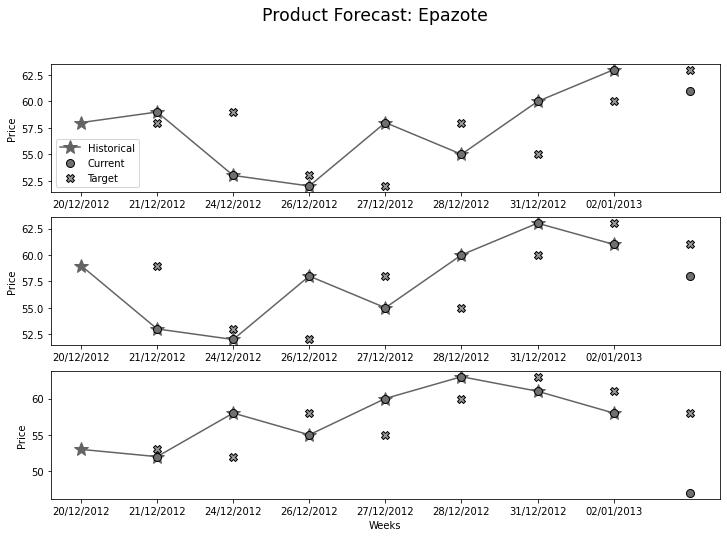

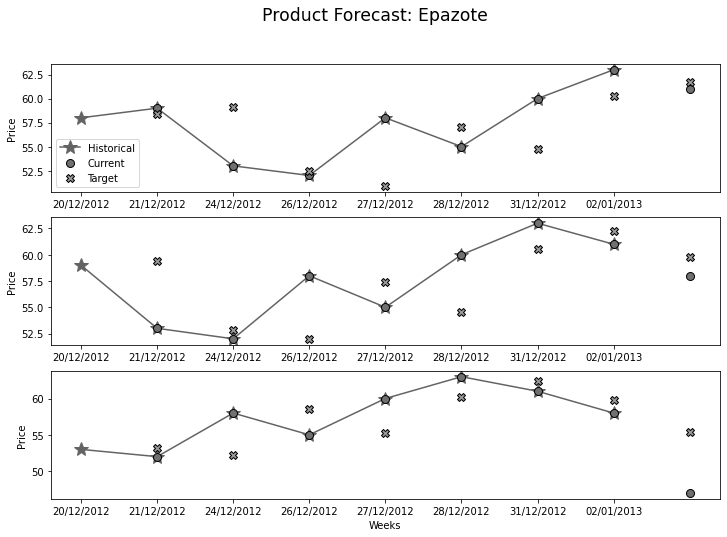

In [ ]:
Epazote = AppliedWindow(product_index=15, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Epazote()

---
 **16. Jícama**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.006593956146389246, 0.08120317757129669], 'simple_rnn': [0.014834005385637283, 0.1217949315905571]} Product Batch  Precio
Fecha                
2017-01-01      4.300
2017-01-08      4.400
2017-01-15      4.000
2017-01-22      4.000
2017-01-29      3.900
...               ...
2019-01-20      7.600
2019-01-27      8.100
2019-02-03     10.400
2019-02-10      8.875
2019-02-17      8.900

[112 rows x 1 columns]


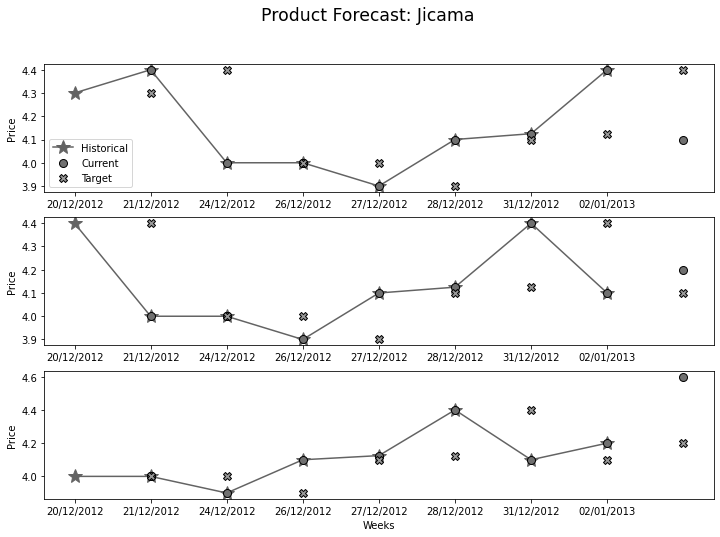

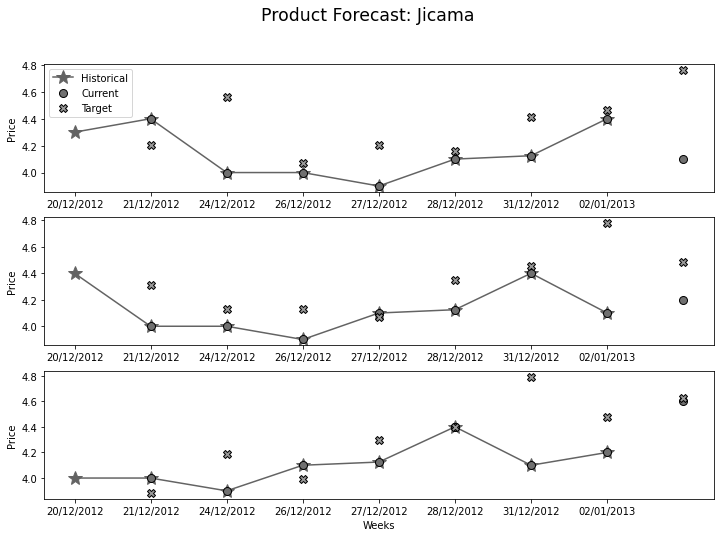

In [ ]:
Jicama = AppliedWindow(product_index=16, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_dataframe, input_width=8, label_width=8, shift=1)
Jicama()

# **Seccion 3.2: Productos Evaluados (no evaluables con ARIMA)**

---
**0. Pera D'anjou #100**
---

/usr/local/lib/python3.7/dist-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)


El rendimiento del método de redes neuronales es: {'Baseline': [0.10923505574464798, 0.3305072784423828], 'simple_rnn': [0.0770101472735405, 0.2775070369243622]} White Batch  Precio
Fecha              
2017-01-01   38.300
2017-01-08   38.300
2017-01-15   36.900
2017-01-22   36.600
2017-01-29   36.100
...             ...
2019-01-20   31.500
2019-01-27   34.000
2019-02-03   32.700
2019-02-10   32.625
2019-02-17   32.100

[112 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


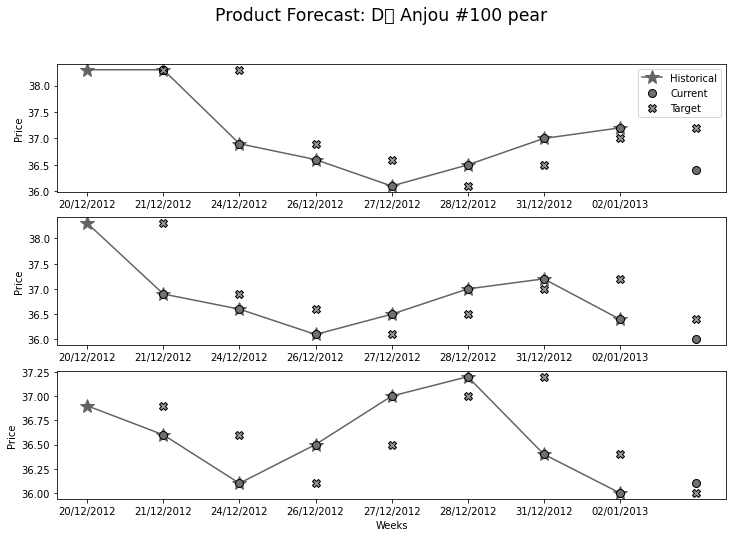

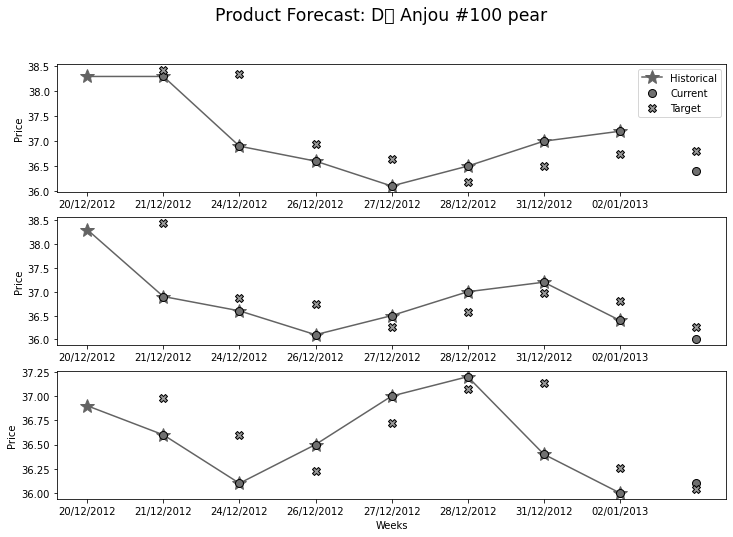

In [ ]:
Pera_D = AppliedWindow(product_index=0, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_white, input_width=8, label_width=8, shift=1)
Pera_D()

---
**1. Plátano Dominico**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.14102506637573242, 0.3755330443382263], 'simple_rnn': [0.21107161045074463, 0.45942530035972595]} White Batch   Precio
Fecha               
2017-01-01   11.0640
2017-01-08   10.6300
2017-01-15   10.6260
2017-01-22   10.6280
2017-01-29   11.1260
...              ...
2019-01-20   10.3760
2019-01-27   12.6260
2019-02-03   14.0020
2019-02-10   14.8475
2019-02-17   14.8780

[112 rows x 1 columns]


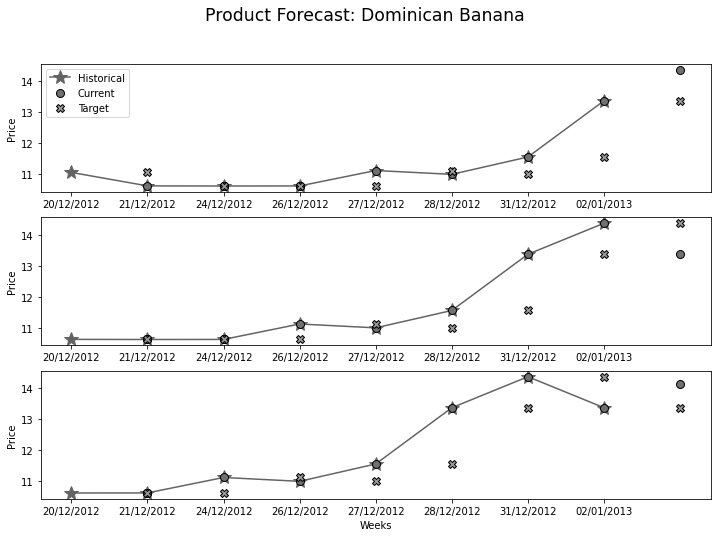

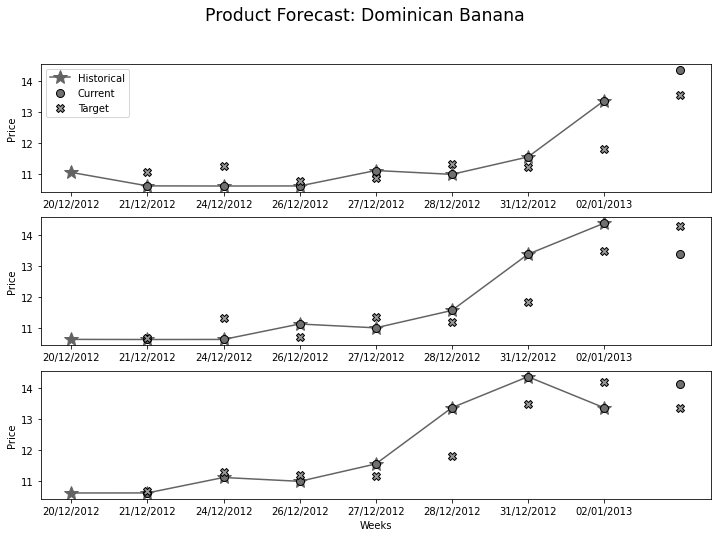

In [ ]:
Platano_D = AppliedWindow(product_index=1, start_year='2017', train_percent=0.6, val_percent=0.1, data=prod_white, input_width=8, label_width=8, shift=1)
Platano_D()

---
**3. Fresa**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.05692993476986885, 0.23859994113445282], 'simple_rnn': [0.04233446344733238, 0.2057534009218216]} White Batch   Precio
Fecha               
2016-01-03   41.5625
2016-01-10   37.5000
2016-01-17   34.2500
2016-01-24   32.5000
2016-01-31   32.0000
...              ...
2019-01-20   42.7500
2019-01-27   39.2500
2019-02-03   39.7500
2019-02-10   39.6875
2019-02-17   40.0000

[164 rows x 1 columns]


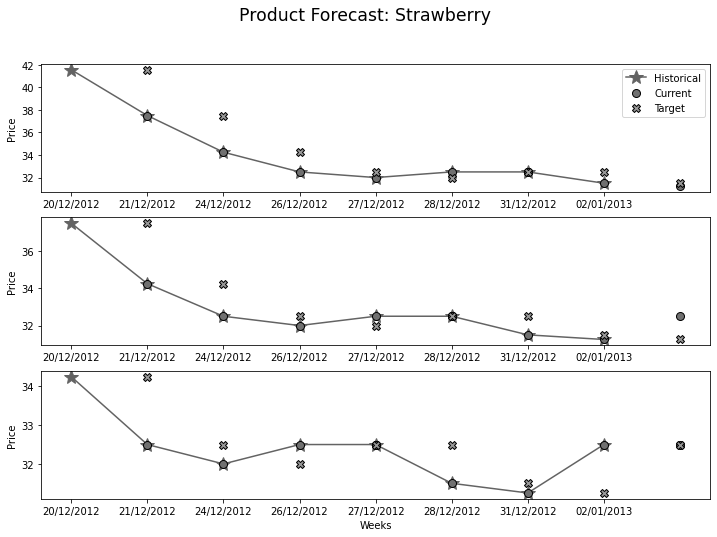

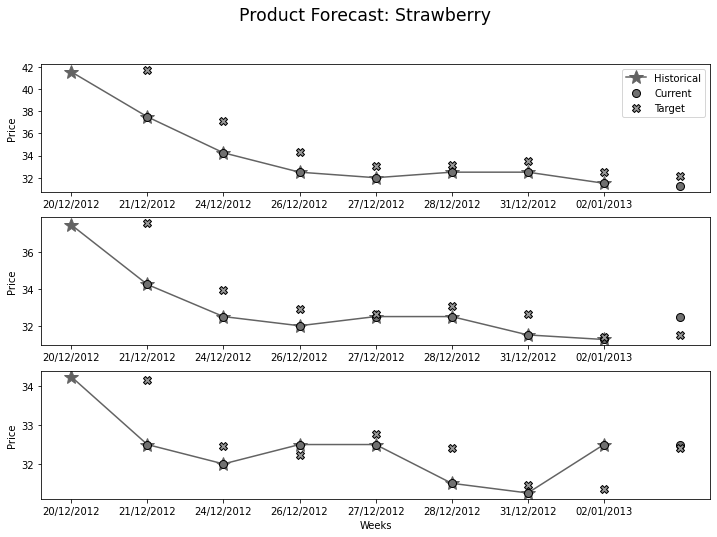

In [ ]:
Fresa = AppliedWindow(product_index=3, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_white, input_width=8, label_width=8, shift=1)
Fresa()

---
**4. Sandía Rayada**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.02323741838335991, 0.1524382382631302], 'simple_rnn': [0.03128708899021149, 0.1768815666437149]} White Batch  Precio
Fecha              
2016-01-03     8.25
2016-01-10     8.00
2016-01-17     6.30
2016-01-24     8.60
2016-01-31     8.40
...             ...
2019-01-20     8.60
2019-01-27     9.00
2019-02-03     8.90
2019-02-10     9.00
2019-02-17     8.70

[164 rows x 1 columns]


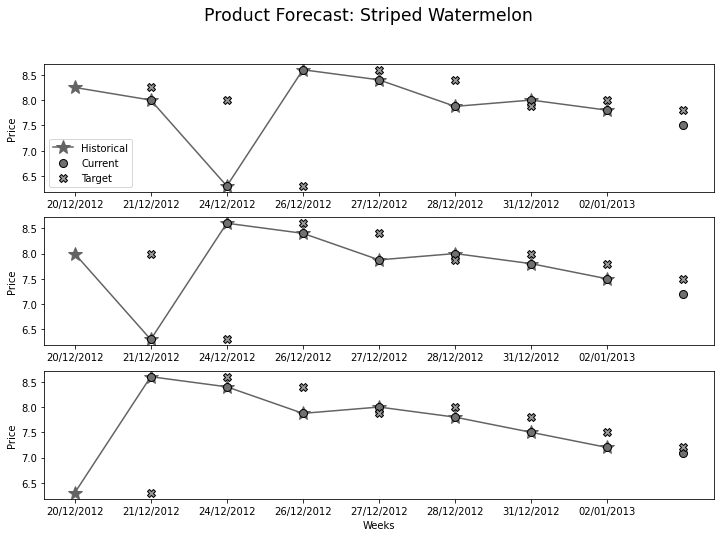

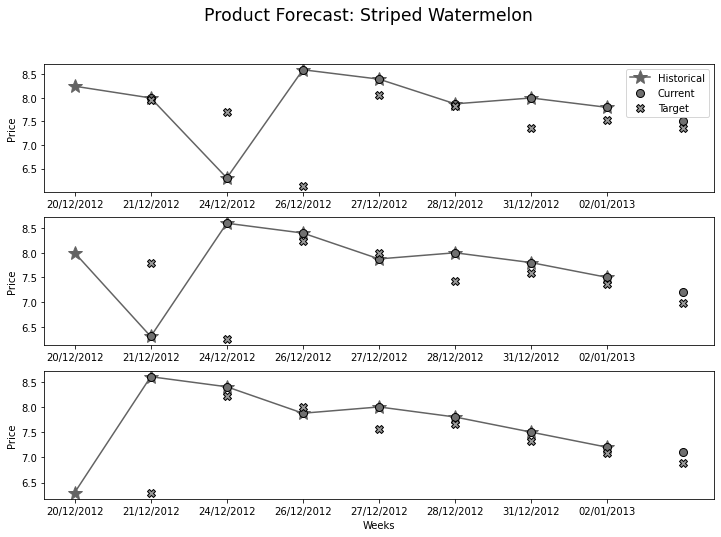

In [ ]:
Sandia_R = AppliedWindow(product_index=4, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_white, input_width=8, label_width=8, shift=1)
Sandia_R()

---
**5. Manzana Red Delicious**
---

El rendimiento del método de redes neuronales es: {'Baseline': [0.06007366627454758, 0.24509930610656738], 'simple_rnn': [0.05836857110261917, 0.24159587919712067]} White Batch  Precio
Fecha              
2016-01-03   27.500
2016-01-10   26.600
2016-01-17   28.000
2016-01-24   28.200
2016-01-31   27.900
...             ...
2019-01-20   39.200
2019-01-27   39.400
2019-02-03   39.200
2019-02-10   38.625
2019-02-17   38.400

[164 rows x 1 columns]


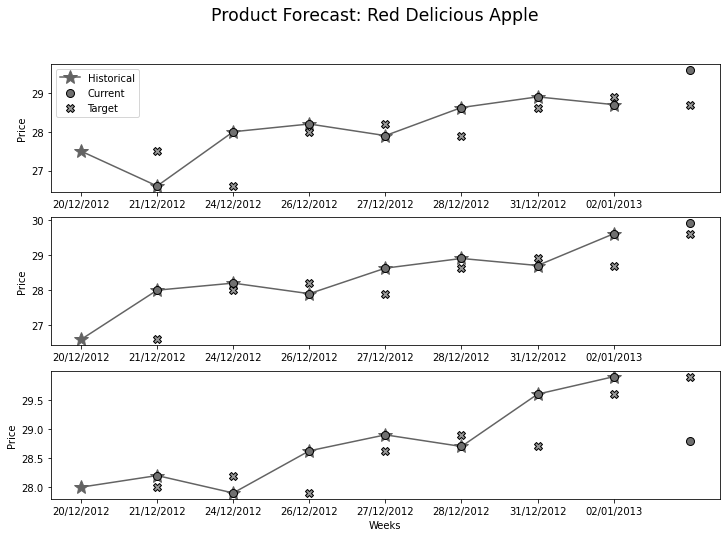

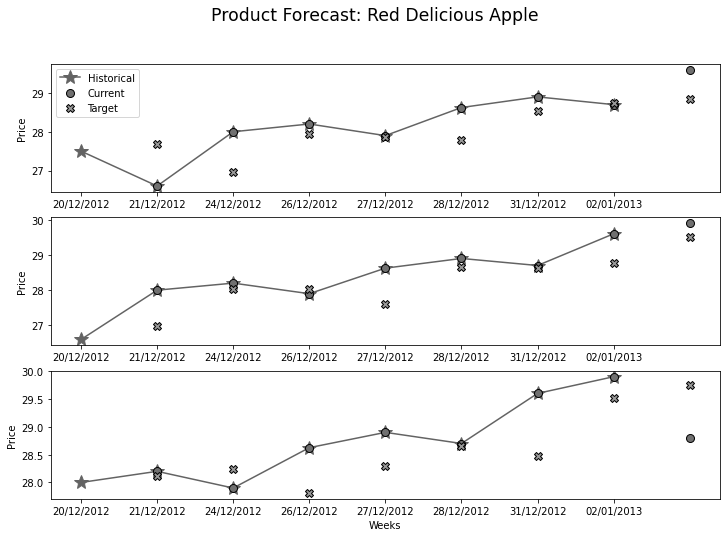

In [ ]:
Manzana_RD = AppliedWindow(product_index=5, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_white, input_width=8, label_width=8, shift=1)
Manzana_RD()

# **Seccion 3.3: Productos Evaluados (con detalles)**

---
**0. Manzana Golden Delicious** (Genera problemas a todo el código)
---

In [ ]:
# # Evaluar de manera individual, para reparar código ejecutar secciones 1 y 2
# Manzana_GD = AppliedWindow(product_index=2, start_year='2016', train_percent=0.6, val_percent=0.1, data=prod_white, input_width=8, label_width=8, shift=1)
# Manzana_GD()

# **Sección 4: Código Obsoleto (comentado, no es necesario ejecutar, solo para consulta)**

In [ ]:
# ## III. Aplicación del Modelo

# ### 0. COLIFLOR GRANDE ###

# # # 1.1. Generar el DataFrame # #
# P0 = prod_dataframe.loc[all_products[0]] # Seleccionar la Coliflor
# P0.columns.name = all_products[0] # Nombrar el DataFrame
# P0_dt = pd.to_datetime(P0.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P0.index = P0_dt # Poner el objeto DateTime como índice
# P0 = P0.resample('W').mean() #Obtener los promedios semanales
# P0 = P0['2017':]
# # P0.plot(subplots=True) # Obtener una gráfica del precio de entrada.


# # # 1.2. Separar los datos # #
# P0_column_indices = {name: i for i, name in enumerate(P0.columns)}
# P0_n = len(P0)

# P0_train = P0[0:int(P0_n*0.5)]
# P0_val = P0[int(P0_n*0.5):int(P0_n*0.9)]
# P0_test = P0[int(P0_n*0.9):]

# num_features = P0.shape[1]

# # 1.3. Normalizar los Datos # # 
# P0_train_mean = P0_train.mean()
# P0_train_std = P0_train.std()

# train_df = (P0_train - P0_train_mean) / P0_train_std
# val_df = (P0_val - P0_train_mean) / P0_train_std
# test_df = (P0_test - P0_train_mean) / P0_train_std

# # print(train_df.shape)

# # ejemplo = np.array(train_df)
# # ds = tf.keras.preprocessing.timeseries_dataset_from_array(
# #     data = ejemplo,
# #     targets = None,
# #     sequence_length = 20,
# #     shuffle = False,
# #     batch_size = 500
# # )
# # i=0
# # for unit in ds:
# #   print(unit)
# # train_df.plot(subplots=True)
# # print(list(ds))

# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])


# print(wide_window)
# # print(P0_column_indices['Precio'])
# print(wide_window.plot())
# # print(wide_window.train)

In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')

# baseline = Baseline(label_index=P0_column_indices['Precio'])
# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(wide_window.val)
# performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=False)
# wide_window.plot(baseline)

# # Rendimiento con la red recurrente ##
# print('****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# val_performance = {}
# performance = {}
# IPython.display.clear_output()
# val_performance['simple_rnn'] = simple_rnn.evaluate( wide_window.val)
# performance['simple_rnn'] = simple_rnn.evaluate( wide_window.test, verbose=0)
# wide_window.plot(model=simple_rnn)


In [ ]:
# ### 1. NOPAL GRANDE ###

# # # 1.1. Generar el DataFrame # #
# P1 = prod_dataframe.loc[all_products[1]] # Seleccionar
# P1.columns.name = all_products[1] # Nombrar el DataFrame
# P1_dt = pd.to_datetime(P1.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P1.index = P1_dt # Poner el objeto DateTime como índice
# P1 = P1.resample('W').mean() #Obtener los promedios semanales
# P1 = P1['2018':]
# P1.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# P1_column_indices = {name: i for i, name in enumerate(P1.columns)}
# P1_n = len(P1)
# P1_train = P1[0:int(P1_n*0.5)]
# P1_val = P1[int(P1_n*0.5):int(P1_n*0.8)]
# P1_test = P1[int(P1_n*0.8):]

# num_features = P1.shape[1]


# # 1.3. Normalizar los Datos # # 
# P1_train_mean = P1_train.mean()
# P1_train_std = P1_train.std()

# train_df = (P1_train - P1_train_mean) / P1_train_std
# val_df = (P1_val - P1_train_mean) / P1_train_std
# test_df = (P1_test - P1_train_mean) / P1_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=10, label_width=10, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=10, label_width=10, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# print(single_step_window)


In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=P1_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=False)

# # Desnormalizar y graficar
# # wide_window.plot(model=baseline)

# norm_inputs, norm_labels = single_step_window.example
# norm_predictions = baseline(norm_inputs)
# inputs = (norm_inputs * P1_train_std) + P1_train_mean
# labels = (norm_labels * P1_train_std) + P1_train_mean
# predictions = (norm_predictions * P1_train_std) + P1_train_mean

# wide_window.plot(model = baseline, predictions=predictions)

# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)

# # Desnormalizar y graficar
# norm_inputs, norm_labels = wide_window.example
# norm_predictions = simple_rnn(norm_inputs)
# inputs = (norm_inputs * P1_train_std) + P1_train_mean
# labels = (norm_labels * P1_train_std) + P1_train_mean
# predictions = (norm_predictions * P1_train_std) + P1_train_mean

# wide_window.plot(model = simple_rnn, predictions=predictions)


In [ ]:
# ### 2. CALABACITA ITALIANA ###

# # # 1.1. Generar el DataFrame # #
# P2 = prod_dataframe.loc[all_products[2]] # Seleccionar
# P2.columns.name = all_products[2] # Nombrar el DataFrame
# P2_dt = pd.to_datetime(P2.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P2.index = P2_dt # Poner el objeto DateTime como índice
# P2 = P2.resample('W').mean() #Obtener los promedios semanales
# P2 = P2['2018':]
# P2.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# P2_column_indices = {name: i for i, name in enumerate(P2.columns)}
# P2_n = len(P2)
# P2_train = P2[0:int(P2_n*0.5)]
# P2_val = P2[int(P2_n*0.5):int(P2_n*0.8)]
# P2_test = P2[int(P2_n*0.8):]

# num_features = P2.shape[1]


# # 1.3. Normalizar los Datos # # 
# P2_train_mean = P2_train.mean()
# P2_train_std = P2_train.std()

# train_df = (P2_train - P2_train_mean) / P2_train_std
# val_df = (P2_val - P2_train_mean) / P2_train_std
# test_df = (P2_test - P2_train_mean) / P2_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=10, label_width=10, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])

# print(P2_test)

In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=P2_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# wide_window.plot(baseline)


# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# wide_window.plot(simple_rnn)
# history.history

In [ ]:
# ### 3. CHAYOTE SIN ESPINAS ###

# # # 1.1. Generar el DataFrame # #
# P3 = prod_dataframe.loc[all_products[3]] # Seleccionar
# P3.columns.name = all_products[3] # Nombrar el DataFrame
# P3_dt = pd.to_datetime(P3.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P3.index = P3_dt # Poner el objeto DateTime como índice
# P3 = P3.resample('W').mean() #Obtener los promedios semanales
# P3 = P3['2018':]
# P3.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# P3_column_indices = {name: i for i, name in enumerate(P3.columns)}
# P3_n = len(P3)
# P3_train = P3[0:int(P3_n*0.5)]
# P3_val = P3[int(P3_n*0.5):int(P3_n*0.8)]
# P3_test = P3[int(P3_n*0.8):]

# num_features = P3.shape[1]


# # 1.3. Normalizar los Datos # # 
# P3_train_mean = P3_train.mean()
# P3_train_std = P3_train.std()

# train_df = (P3_train - P3_train_mean) / P3_train_std
# val_df = (P3_val - P3_train_mean) / P3_train_std
# test_df = (P3_test - P3_train_mean) / P3_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=8, label_width=8, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=8, label_width=8, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])



In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=P3_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# # Desnormalizar y graficar
# # wide_window.plot(model=baseline)

# norm_inputs, norm_labels = single_step_window.example
# norm_predictions = baseline(norm_inputs)
# inputs = (norm_inputs * P3_train_std) + P3_train_mean
# labels = (norm_labels * P3_train_std) + P3_train_mean
# predictions = (norm_predictions * P3_train_std) + P3_train_mean

# wide_window.plot(model = baseline, inputs=inputs, labels=labels, predictions=predictions)

# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)

# # Desnormalizar y graficar
# norm_inputs, norm_labels = wide_window.example
# norm_predictions = simple_rnn(norm_inputs)
# inputs = (norm_inputs * P3_train_std) + P3_train_mean
# labels = (norm_labels * P3_train_std) + P3_train_mean
# predictions = (norm_predictions * P3_train_std) + P3_train_mean

# wide_window.plot(model = simple_rnn, inputs=inputs, labels=labels, predictions=predictions)


In [ ]:
# ### 5. TOMATE SALADETTE ###

# # # 1.1. Generar el DataFrame # #
# P5 = prod_dataframe.loc[all_products[5]] # Seleccionar
# P5.columns.name = all_products[5] # Nombrar el DataFrame
# P5_dt = pd.to_datetime(P5.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P5.index = P5_dt # Poner el objeto DateTime como índice
# P5 = P5.resample('W').mean() #Obtener los promedios semanales
# P5 = P5['2017':]
# P5.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# P5_column_indices = {name: i for i, name in enumerate(P5.columns)}
# P5_n = len(P5)
# P5_train = P5[0:int(P5_n*0.5)]
# P5_val = P5[int(P5_n*0.5):int(P5_n*0.8)]
# P5_test = P5[int(P5_n*0.8):]

# num_features = P5.shape[1]


# # 1.3. Normalizar los Datos # # 
# P5_train_mean = P5_train.mean()
# P5_train_std = P5_train.std()

# train_df = (P5_train - P5_train_mean) / P5_train_std
# val_df = (P5_val - P5_train_mean) / P5_train_std
# test_df = (P5_test - P5_train_mean) / P5_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=5, label_width=5, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])

# print(P5_test)


In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=P5_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# wide_window.plot(baseline)



# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# wide_window.plot(simple_rnn)
# history.history

In [ ]:
# ### 6. NARANJA VALENCIA GRANDE ###

# # # 1.1. Generar el DataFrame # #
# P6 = prod_dataframe.loc[all_products[6]] # Seleccionar
# P6.columns.name = all_products[6] # Nombrar el DataFrame
# P6_dt = pd.to_datetime(P6.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P6.index = P6_dt # Poner el objeto DateTime como índice
# P6 = P6.resample('W').mean() #Obtener los promedios semanales
# P6 = P6['2018':]
# P6.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# P6_column_indices = {name: i for i, name in enumerate(P6.columns)}
# P6_n = len(P6)
# P6_train = P6[0:int(P6_n*0.5)]
# P6_val = P6[int(P6_n*0.5):int(P6_n*0.9)]
# P6_test = P6[int(P6_n*0.9):]

# num_features = P6.shape[1]


# # 1.3. Normalizar los Datos # # 
# P6_train_mean = P6_train.mean()
# P6_train_std = P6_train.std()

# train_df = (P6_train - P6_train_mean) / P6_train_std
# val_df = (P6_val - P6_train_mean) / P6_train_std
# test_df = (P6_test - P6_train_mean) / P6_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=10, label_width=10, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])

# P6_test

In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=P6_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# wide_window.plot(baseline)



# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# wide_window.plot(simple_rnn)
# history.history

In [ ]:
# ### 7. AGUACATE HASS ###

# # # 1.1. Generar el DataFrame # #
# P7 = prod_dataframe.loc[all_products[7]] # Seleccionar
# P7.columns.name = all_products[7] # Nombrar el DataFrame
# P7_dt = pd.to_datetime(P7.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# P7.index = P7_dt # Poner el objeto DateTime como índice
# P7 = P7.resample('W').mean() #Obtener los promedios semanales
# P7 = P7['2017':]
# P7.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# P7_column_indices = {name: i for i, name in enumerate(P7.columns)}
# P7_n = len(P7)
# P7_train = P7[0:int(P7_n*0.8)]
# P7_val = P7[int(P7_n*0.8):int(P7_n*0.9)]
# P7_test = P7[int(P7_n*0.9):]

# num_features = P7.shape[1]


# # 1.3. Normalizar los Datos # # 
# P7_train_mean = P7_train.mean()
# P7_train_std = P7_train.std()

# train_df = (P7_train - P7_train_mean) / P7_train_std
# val_df = (P7_val - P7_train_mean) / P7_train_std
# test_df = (P7_test - P7_train_mean) / P7_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=3, label_width=3, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])

# P7_test

In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=P7_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# wide_window.plot(baseline)



# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# wide_window.plot(simple_rnn)
# history.history

In [ ]:
# ### B. Plátano Dominico ###

# # # 1.1. Generar el DataFrame # #
# PB = prod_white.loc[all_white[1]] # Seleccionar
# PB.columns.name = all_white[1] # Nombrar el DataFrame
# PB_dt = pd.to_datetime(PB.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# PB.index = PB_dt # Poner el objeto DateTime como índice
# PB = PB.resample('W').mean() #Obtener los promedios semanales
# PB = PB['2018':]
# PB.plot(subplots=True) # Obtener una gráfica del precio de entrada.


# # # 1.2. Separar los datos # #
# PB_column_indices = {name: i for i, name in enumerate(PB.columns)}
# PB_n = len(PB)
# PB_train = PB[0:int(PB_n*0.7)]
# PB_val = PB[int(PB_n*0.7):int(PB_n*0.9)]
# PB_test = PB[int(PB_n*0.9):]

# num_features = PB.shape[1]


# # 1.3. Normalizar los Datos # # 
# PB_train_mean = PB_train.mean()
# PB_train_std = PB_train.std()

# train_df = (PB_train - PB_train_mean) / PB_train_std
# val_df = (PB_val - PB_train_mean) / PB_train_std
# test_df = (PB_test - PB_train_mean) / PB_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=5, label_width=5, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# print(test_df)


In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=PB_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# wide_window.plot(baseline)



# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# wide_window.plot(simple_rnn)
# history.history

In [ ]:
all_products[7]
all_white

array(['D\x92 Anjou #100 pear', 'Dominican Banana',
       'Golden Delicious Apple', 'Strawberry', 'Striped Watermelon',
       'Red Delicious Apple'], dtype=object)

In [ ]:
# ### B. Plátano Dominico ###

# # # 1.1. Generar el DataFrame # #
# PC = prod_white.loc[all_white[0]] # Seleccionar
# PC.columns.name = all_white[0] # Nombrar el DataFrame
# PC_dt = pd.to_datetime(PC.pop('Fecha'), dayfirst=True) # Extraer la fecha en como objeto DateTime  
# PC.index = PC_dt # Poner el objeto DateTime como índice
# PC = PC.resample('W').mean() #Obtener los promedios semanales
# PC = PC['2017':]
# PC.plot(subplots=True) # Obtener una gráfica del precio de entrada.



# # # 1.2. Separar los datos # #
# PC_column_indices = {name: i for i, name in enumerate(PC.columns)}
# PC_n = len(PC)
# PC_train = PC[0:int(PC_n*0.7)]
# PC_val = PC[int(PC_n*0.8):int(PC_n*0.9)]
# PC_test = PC[int(PC_n*0.9):]

# num_features = PC.shape[1]


# # 1.3. Normalizar los Datos # # 
# PC_train_mean = PC_train.mean()
# PC_train_std = PC_train.std()

# train_df = (PC_train - PC_train_mean) / PC_train_std
# val_df = (PC_val - PC_train_mean) / PC_train_std
# test_df = (PC_test - PC_train_mean) / PC_train_std



# # # 1.4. Crear un Modelo de desplazamiento individual y otro múltiple # #
# single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])
# wide_window = WindowGenerator(input_width=10, label_width=10, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Precio'])

# val_df

In [ ]:
# ## Rendimiento  con el modelo base ##
# print('****MODELO BASE****')
# baseline = Baseline(label_index=PC_column_indices['Precio'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=True)

# wide_window.plot(baseline)



# ## Rendimiento con la red recurrente ##
# print('*****MODELO RECURRENTE****')
# history = compile_and_fit(simple_rnn, wide_window)
# wide_window.plot(simple_rnn)
# history.history

In [ ]:
# all_white